### ABOUT:
This workflow leverages Google Earth Engine and Python to develop satellite-derived elevation data in intertidal zones. Workflow is still messy, and currently is set for Laguna Madre, TX and using Landsat 8 and 9 images. Interpolation via kriging does not work due to RAM issues, whereas interpolation via IDW does not perform well.

Contact info: antoniocantu91@gmail.com

Harte Research Institute, Texas A&M University-Corpus Christi

1. Setup Google Earth Engine

In [ ]:
# Install required packages
!pip install earthengine-api geemap pykrige

# Import necessary libraries
import ee
import geemap #for visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #for plotting and viz
from pykrige.ok import OrdinaryKriging #for Kriging interpolation
import folium

# Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize(project='ee-acantu') #link personal GEE account

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.6/979.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.5 MB/s eta 0:00:00


2. Define study area, build an Image Collection, NDWI function

In [ ]:
# Define study area (modify coordinates for your location)
AB = ee.Geometry.Polygon(
        [[[-82.42311032787532,27.80932302862],
          [-82.37899335399837,27.80932302862],
          [-82.37899335399837,27.855698823474853],
          [-82.42311032787532,27.855698823474853],
          [-82.42311032787532,27.80932302862]]]); #Alafia Bank

LM = ee.Geometry.Polygon(
        [[[-97.21593685341571,27.6341835587753],
          [-97.28048153115009,27.670676538672083],
          [-97.38759823036884,27.44544281226437],
          [-97.45626278115009,27.207535521513066],
          [-97.37386532021259,27.198985779001067],
          [-97.31481380654071,27.44422407827094],
          [-97.21593685341571,27.6341835587753]]]); #Laguna Madre

HM = ee.Geometry.Polygon(
        [[[-82.83805659645788,28.05456666957485],
          [-82.76664546364538,28.05017333561471],
          [-82.76424220436803,28.090766963097003],
          [-82.81179240578405,28.09364428719258],
          [-82.8090458237528,28.13543250494398],
          [-82.84475139015905,28.13618938768033],
          [-82.83805659645788,28.05456666957485]]]); # Honeymoon Island

## =====================================================================================================
# Load Sentinel-2 Image Collection (filter by cloud cover and date)
s2_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(LM) \
    .filterDate('2022-01-01', '2024-12-31') \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 5)
print('# of S2 images:', s2_collection.size().getInfo())# print the number of images found in the search

# Function to make landsat Bands compatible
def harmonize_landsat(image, sensor):
    # Harmonize band names to match: [Blue, Green, Red, NIR, SWIR1, SWIR2]
    if sensor == 'L7':
        bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']  # Landsat 7 (no B6)
    else:  # L8 or L9
        bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']

    common_names = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']

    image = image.select(bands, common_names)
    return image.clip(LM)

l7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_TOA") \
    .filterBounds(LM) \
    .filterDate('2022-01-01', '2024-12-31') \
    .filterMetadata('CLOUD_COVER', 'less_than', 5) \
    .map(lambda img: harmonize_landsat(img, 'L7'))
#print('# of L7 images:', l7.size().getInfo())# print the number of images found in the search

l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA") \
    .filterBounds(LM) \
    .filterDate('2022-01-01', '2024-12-31') \
    .filterMetadata('CLOUD_COVER', 'less_than', 5) \
    .map(lambda img: harmonize_landsat(img, 'L8'))
#print('# of L8 images:', l8.size().getInfo())# print the number of images found in the search

l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_TOA") \
    .filterBounds(LM) \
    .filterDate('2022-01-01', '2024-12-31') \
    .filterMetadata('CLOUD_COVER', 'less_than', 5) \
    .map(lambda img: harmonize_landsat(img, 'L9'))
#print('# of L9 images:', l9.size().getInfo())# print the number of images found in the search
'''
# merge landsat collections
l_collection = l7.merge(l8).merge(l9);
print('# of Landsat images:', l_collection.size().getInfo())# print the number of images found in the search
#first_img = l_collection.first()
#print(first_img.getInfo())
'''
# alternatively, merge only L8 and 9
l_collection = l8.merge(l9);
print('# of Landsat images:', l_collection.size().getInfo())# print the number of images found in the search

## ====================================================================================================

# Function to compute NDWI and MNDWI
def ndwi(image):
    ndwi_image = image.normalizedDifference(['B5', 'B3']).rename('NDWI')  # (Green - NIR) / (Green + NIR)
    return ndwi_image.copyProperties(image, ['system:time_start'])

def mndwi(image):
    mndwi_image = image.normalizedDifference(['B7', 'B3']).rename('MNDWI')  # (Green - SWIR1) / (Green + SWIR1)
    return mndwi_image.copyProperties(image, ['system:time_start'])

# this function masked areas where you have values lower or equal to 0.4
def mask_land (image):
  return image.updateMask(image.lte(0.4));

# Function to clip to aoi
def clip_aoi(image):
  return image.clip(LM)



# of S2 images: 36
# of Landsat images: 25


2.1 Map NDWI function to image collection and compute STD

In [ ]:
## Using NDWI
'''
# SENTINEL
# Apply the NDWI function to the image collection
s2_ndwi = s2_collection.map(ndwi)
s2_ndwi = s2_ndwi.map(clip_aoi)
#s2_ndwi = s2_ndwi.map(mask_land)

# Compute standard deviation to map intertidal areas
NDWI_STD=s2_ndwi.reduce(ee.Reducer.stdDev());# Now the entire collection was reduced to one-single image showing STD

#Mask the non-watery parts of the image, where NDWI < 0.4.
stdMasked = NDWI_STD.updateMask(NDWI_STD.gte(0.32).And(NDWI_STD.lte(0.42)));#EQ("="), GTE(">="), GT(">"), LT("<"), LTE("<=");
zones=NDWI_STD.gte(0.32).And(NDWI_STD.lte(0.40))
zones=zones.updateMask(zones.neq(0))
zones=zones.updateMask(zones.neq(0))
'''
# LANDSAT
'''
### For HM:
# Before applying the NDWI function to the Landsat collection, filter out the corrupted image
l_collection = l_collection.filter(ee.Filter.neq('system:index', 'LE07_017040_20220512')) \
                            .filter(ee.Filter.neq('system:index', 'LE07_017040_20220114'))

## For LM:
# Filter out the corrupted image before applying reduceToVectors
l_collection = l_collection.filter(ee.Filter.neq('system:index', 'LE07_026041_20220318')) \
                           .filter(ee.Filter.neq('system:index', 'LE07_026041_20231017')) # Changed the image ID
'''
# Apply the NDWI function to the image collection
l_ndwi = l_collection.map(ndwi)
l_ndwi = l_ndwi.map(clip_aoi)
#l_ndwi = l_ndwi.map(mask_land)
first_img = l_ndwi.first()
print(first_img.getInfo())

# Compute standard deviation to map intertidal areas
NDWI_STD = l_ndwi.reduce(ee.Reducer.stdDev());# Now the entire collection was reduced to one-single image showing STD

#Mask the non-watery parts of the image, where NDWI > 0.21
stdMasked = NDWI_STD.updateMask(NDWI_STD.gte(0.19)); #.And(NDWI_STD.lte(0.45)));#EQ("="), GTE(">="), GT(">"), LT("<"), LTE("<=");


## Using MNDWI
'''
# SENTINEL
# Apply the MNDWI function to the image collection
s2_mndwi = s2_collection.map(mndwi)
s2_mndwi = s2_mndwi.map(clip_aoi)

# Compute standard deviation to map intertidal areas
MNDWI_STD=s2_mndwi.reduce(ee.Reducer.stdDev())# Now the entire collection was reduced to one-single image showing STD

#Mask the non-watery parts of the image, where NDWI < 0.4.
stdMasked = MNDWI_STD.updateMask(MNDWI_STD.gte(0.25).And(MNDWI_STD.lte(0.45)));#EQ("="), GTE(">="), GT(">"), LT("<"), LTE("<=");
zones=MNDWI_STD.gte(0.2).And(MNDWI_STD.lte(0.35))
zones=zones.updateMask(zones.neq(0))
zones=zones.updateMask(zones.neq(0))


# LANDSAT
# Apply the MNDWI function to the image collection
l9_mndwi = l9_collection.map(mndwi)
l9_mndwi = l9_mndwi.map(clip_aoi)

# Compute standard deviation to map intertidal areas
MNDWI_STD=l9_mndwi.reduce(ee.Reducer.stdDev())# Now the entire collection was reduced to one-single image showing STD

#Mask the non-watery parts of the image, where NDWI < 0.4.
stdMasked = MNDWI_STD.updateMask(MNDWI_STD.gte(0.25)); #.And(MNDWI_STD.lte(0.35)));#EQ("="), GTE(">="), GT(">"), LT("<"), LTE("<=");
zones=MNDWI_STD.gte(0.2).And(MNDWI_STD.lte(0.35))
zones=zones.updateMask(zones.neq(0))
zones=zones.updateMask(zones.neq(0))
'''

# Assume 'image' is your ee.Image
crs_info = stdMasked.projection()
print('CRS:', crs_info.getInfo())

{'type': 'Image', 'bands': [{'id': 'NDWI', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'dimensions': [772, 1747], 'origin': [2403, 2967], 'crs': 'EPSG:32614', 'crs_transform': [30, 0, 580785, 0, -30, 3150915]}], 'properties': {'system:time_start': 1641401871946, 'system:footprint': {'type': 'Polygon', 'coordinates': [[[-97.21593685341571, 27.6341835587753], [-97.2804815311501, 27.67067653867208], [-97.38759823036885, 27.44544281226437], [-97.45626278115009, 27.207535521513066], [-97.37386532021259, 27.198985779001063], [-97.31481380654071, 27.44422407827094], [-97.21593685341571, 27.6341835587753]]]}, 'system:index': '1_LC08_026041_20220105'}}
CRS: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}


### NOTES:
- In Alafia Bank, Landsat images work best with NDWI gte 0.23. Dates = Jan 2022 - Dec 2023
- In Honemoon Island, Landsat images work best with NDWI gte 0.21, but some L7 images may be corrupted. Dates = Jan 2022 - Dec 2023
- In Laguna Madre, Landsat images work best with NDWI gte 0.21, dates can be extended to Jan 2022- Dec 2024
    

2.2 Visualize intertidal areas based on NDWI STD

In [ ]:

# Set visualization parameters.
palette = ['blue','yellow'];
vis_params = {
              'min': 0.19,
              'max': 0.3,
              'dimensions': 500,
              'palette':palette,
              };

# Using geemap
# Initialize map
Map = geemap.Map(basemap='SATELLITE')
Map.centerObject(LM, 10)

# Add standard deviation of NDWI to highlight intertidal areas
Map.addLayer(stdMasked, vis_params, 'Intertidal mask', shown=True)

# Display map
Map


Map(center=[27.426560541777874, -97.34521603298752], controls=(WidgetControl(options=['position', 'transparent…

2.3 Masking and exporting intertidal areas as vector

In [ ]:
#mask areas with STD values greater than .21
zones=NDWI_STD.gte(0.21)
zones=zones.updateMask(zones.neq(0))



# creating vector polygon representing the intertidal zone for the study area
vectors=zones.addBands(NDWI_STD).reduceToVectors(
  crs= 'EPSG:4326', # always double check
  scale= 10,
  #crsTransform=[60, 0, 399960, 0, -60, 5900020],
  geometryType= 'polygon',
  labelProperty= 'stdMasked',
  eightConnected= False,
  geometry= LM, # change location accordingly
  maxPixels=100e9,
  geometryInNativeProjection=True,
  reducer= ee.Reducer.mean(),
)

vectors.getInfo() # showing vectors propertiers
print('numbers of vectors identified: ' + str(vectors.size().getInfo()))# print the numbers of vectors identified

numbers of vectors identified: 1079


###2.4 Create imageCollection with ndwi that will later be used for Otsu thresholding

In [ ]:
# function to clip areas into identified vectors
def clip_image2 (image):
  return image.clip(vectors)
'''
# Clipping all images in the collection into the vector areas
NWI2=l_collection.map(ndwi);

intertidal_zones=NWI2.map(clip_image2)
'''
# ImageCollection without clipping to intertidal extent only
intertidal_zones=l_collection.map(ndwi);

first_image = intertidal_zones.first()
print(first_image.getInfo())

# Visualizing vectors for intertidal areas
# Set visualization parameters.
palette = ['blue','yellow', 'red'];
#palette= ['0000FF', '00FF00', 'FF0000']
vis_params = {
              'min': -0.6,
              'max': 0.5,
              'dimensions': 500,
              'palette':palette,
              };
Map.addLayer(intertidal_zones, vis_params, 'Intertidal Zones')
Map

{'type': 'Image', 'bands': [{'id': 'NDWI', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'dimensions': [772, 1747], 'origin': [2403, 2967], 'crs': 'EPSG:32614', 'crs_transform': [30, 0, 580785, 0, -30, 3150915]}], 'properties': {'system:time_start': 1641401871946, 'system:footprint': {'type': 'Polygon', 'coordinates': [[[-97.21593685341571, 27.6341835587753], [-97.2804815311501, 27.67067653867208], [-97.38759823036885, 27.44544281226437], [-97.45626278115009, 27.207535521513066], [-97.37386532021259, 27.198985779001063], [-97.31481380654071, 27.44422407827094], [-97.21593685341571, 27.6341835587753]]]}, 'system:index': '1_LC08_026041_20220105'}}


Map(center=[27.42656054177872, -97.34521603298718], controls=(WidgetControl(options=['position', 'transparent_…

2.5 Export vectors as .shp and export NDWI image clipped to intertidal areas

######*This is optional step to create a shapefile of intertidal zones identified via NDWI_STD*

In [ ]:
'''
task= ee.batch.Export.table.toDrive(collection= stdMasked, description='Intertidal_NDWI_STD_LM', fileFormat= 'SHP');#  we need to create a batch in order to export ee images using python
task.start()# starting the batch
#vectors2.getInfo()

#task.status # check the current status of your exportation
'''

"\ntask= ee.batch.Export.table.toDrive(collection= stdMasked, description='Intertidal_NDWI_STD_LM', fileFormat= 'SHP');#  we need to create a batch in order to export ee images using python\ntask.start()# starting the batch\n#vectors2.getInfo()\n\n#task.status # check the current status of your exportation\n"

# =========== CHECK POINT =========================================

### Step 3. Waterline extraction (Otsu thresholding)

In [ ]:
import datetime
from skimage import filters

# Otsu function adapted to run inside Earth Engine
def otsu_threshold(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum_total = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])

    def compute(i):
        counts_slice = counts.slice(0, 0, i.add(1))
        means_slice = means.slice(0, 0, i.add(1))
        w_bg = counts_slice.reduce(ee.Reducer.sum(), [0]).get([0])
        sum_bg = means_slice.multiply(counts_slice).reduce(ee.Reducer.sum(), [0]).get([0])
        mean_bg = ee.Number(sum_bg).divide(w_bg)
        w_fg = ee.Number(total).subtract(w_bg)
        sum_fg = ee.Number(sum_total).subtract(sum_bg)
        mean_fg = ee.Number(sum_fg).divide(w_fg)
        between_var = w_bg.multiply(w_fg).multiply(mean_bg.subtract(mean_fg).pow(2))
        return between_var

    # Modification: Get the length of the histogram counts as a number
    num_bins = counts.length().get([0]) # Get the length of counts as a number

    indices = ee.List.sequence(1, num_bins.subtract(1)) # Use the numeric length
    variances = indices.map(lambda i: compute(ee.Number(i)))

    max_value = ee.List(variances).reduce(ee.Reducer.max())
    max_idx = ee.List(variances).indexOf(max_value)

    # Change: Access means using a list of indices
    threshold = means.get([max_idx]) # Pass max_idx as a list
    return threshold


# Function to apply threshold to extract waterline
def extract_waterline(image):
    ndwi = image.select('NDWI')

    histogram = ndwi.reduceRegion(
        reducer=ee.Reducer.histogram(255),
        geometry=LM,
        scale=30,
        maxPixels=1e9
    ).get('NDWI')

    # Compute threshold as a Number
    threshold_number = ee.Algorithms.If(histogram, otsu_threshold(histogram), 0.2)
    threshold_number = ee.Number(threshold_number)  # Ensure it is a Number

    # Create threshold image for comparison
    threshold_image = ee.Image.constant(threshold_number)

    # Create binary water mask: water = 1, land = 0
    binary = ndwi.lt(threshold_image).rename('binary')

    # Return both NDWI and binary bands
    return image.addBands(binary) \
                .set('otsu_threshold', threshold_number) \
                .copyProperties(image, ['system:time_start'])

# Apply function to imageCollection
waterline_collection = intertidal_zones.map(extract_waterline)
print(waterline_collection.limit(5).getInfo())
#print(waterline_collection.aggregate_array('otsu_threshold').getInfo())



{'type': 'ImageCollection', 'bands': [], 'features': [{'type': 'Image', 'bands': [{'id': 'NDWI', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'dimensions': [772, 1747], 'origin': [2403, 2967], 'crs': 'EPSG:32614', 'crs_transform': [30, 0, 580785, 0, -30, 3150915]}, {'id': 'binary', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 1}, 'dimensions': [772, 1747], 'origin': [2403, 2967], 'crs': 'EPSG:32614', 'crs_transform': [30, 0, 580785, 0, -30, 3150915]}], 'properties': {'system:time_start': 1641401871946, 'system:footprint': {'type': 'Polygon', 'coordinates': [[[-97.21593685341571, 27.6341835587753], [-97.2804815311501, 27.67067653867208], [-97.38759823036885, 27.44544281226437], [-97.45626278115009, 27.207535521513066], [-97.37386532021259, 27.198985779001063], [-97.31481380654071, 27.44422407827094], [-97.21593685341571, 27.6341835587753]]]}, 'otsu_threshold': -0.18351889325679252, 'system:index': '1_LC08_026041_20220105'}}, {

#### 3.2 Visualize Otsu threshold water masks

In [ ]:
# ==== Visualize waterline masks =======

# Convert the ImageCollection to a list and select a few images
waterline_list = waterline_collection.toList(waterline_collection.size())

# Select 3 example images (adjust indices as needed)
example1 = ee.Image(waterline_list.get(24)).select('binary')
example2 = ee.Image(waterline_list.get(10)).select('binary')
example3 = ee.Image(waterline_list.get(2)).select('binary')

vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['000000', '00FFFF']  # black background, cyan waterlines
}

Map.addLayer(example1, vis_params, 'Waterline 1')
#Map.addLayer(example2, vis_params, 'Waterline 2')
Map.addLayer(example3, vis_params, 'Waterline 3')

# Optionally center the map on one of the waterlines
Map.centerObject(example1, 11)  # Zoom level 11 for context

Map

Map(center=[27.426560541777874, -97.34521603298752], controls=(WidgetControl(options=['position', 'transparent…

### 3.3 Apply Canny Edge Detection to extract shoreline based on Otsu's land/water layer.

In [ ]:
## Create Shoreline Edges Using a Canny Edge Detector

def detect_shoreline_edges(image):
    binary = image.select('binary')

    # Apply Canny edge detector
    edges = ee.Algorithms.CannyEdgeDetector(binary, threshold=0.99, sigma=1.0)

    # Optionally mask edges
    edges = edges.updateMask(edges)

    # Retain metadata and set an edge-specific property
    return edges.set({
        'system:time_start': image.get('system:time_start'),
        'otsu_threshold': image.get('otsu_threshold')
    })

shoreline_edges = waterline_collection.map(detect_shoreline_edges)


'''
# Pick a few shoreline edge images
sample_edges = shoreline_edges.toList(5)
for i in range(5):
    edge_image = ee.Image(sample_edges.get(i))
    Map.addLayer(edge_image, {'palette': ['cyan']}, f'Shoreline Edge {i+1}')

Map
'''

"\n# Pick a few shoreline edge images\nsample_edges = shoreline_edges.toList(5)\nfor i in range(5):\n    edge_image = ee.Image(sample_edges.get(i))\n    Map.addLayer(edge_image, {'palette': ['cyan']}, f'Shoreline Edge {i+1}')\n\nMap\n"

In [ ]:
### Let's inspect 'shoreline_edges to make sure all metadata is there
# Convert to list to inspect a few images
sample_edges = shoreline_edges.toList(5)

# Check bands and properties for each image
for i in range(5):
    image = ee.Image(sample_edges.get(i))
    info = image.getInfo()

    print(f"Image {i+1}")
    print("Bands:", [band['id'] for band in info['bands']])
    print("Properties:")
    for key, val in info['properties'].items():
        print(f"  {key}: {val}")
    print("-" * 30)

for i in range(5):
    image = ee.Image(sample_edges.get(i))
    timestamp = ee.Date(image.get('system:time_start')).format('yyyy-MM-dd HH:mm')
    print(f"Image {i+1} timestamp: {timestamp.getInfo()}")


Image 1
Bands: ['binary']
Properties:
  system:time_start: 1641401871946
  system:footprint: {'type': 'Polygon', 'coordinates': [[[-97.21593685341571, 27.6341835587753], [-97.2804815311501, 27.67067653867208], [-97.38759823036885, 27.44544281226437], [-97.45626278115009, 27.207535521513066], [-97.37386532021259, 27.198985779001063], [-97.31481380654071, 27.44422407827094], [-97.21593685341571, 27.6341835587753]]]}
  otsu_threshold: -0.18351889325679252
  system:index: 1_LC08_026041_20220105
------------------------------
Image 2
Bands: ['binary']
Properties:
  system:time_start: 1648313844376
  system:footprint: {'type': 'Polygon', 'coordinates': [[[-97.21593685341571, 27.6341835587753], [-97.2804815311501, 27.67067653867208], [-97.38759823036885, 27.44544281226437], [-97.45626278115009, 27.207535521513066], [-97.37386532021259, 27.198985779001063], [-97.31481380654071, 27.44422407827094], [-97.21593685341571, 27.6341835587753]]]}
  otsu_threshold: -0.11335116642034145
  system:index: 

#=============== Checkpoint ===============================
###Everything good up to this point (4/10/2025)
##### Next:
- add water level elevation data to shoreline_edges
- vectorize
- interpolate
- generate and export DEM

## Step 4. Add elevation data to each shoreline/waterline

#### 4.1 Extract timestamp and then create a .csv with water level data

In [ ]:
##### Extract timestamps from images so that water level data can be manually assigned to corresponding dates and times.

# Get list of all images in the waterline collection
image_list = waterline_collection.toList(waterline_collection.size())

# Function to extract timestamp for each image
def get_time_info(i):
    image = ee.Image(image_list.get(i))
    time_start = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd HH:mm:ss')
    return time_start

# Loop through and get timestamps
timestamps = [get_time_info(i).getInfo() for i in range(image_list.size().getInfo())]

# Display results in a table

df = pd.DataFrame(timestamps, columns=['timestamp'])
print(df)


from google.colab import drive
drive.mount('/content/gdrive/')
'''
df.to_csv('/content/gdrive/My Drive/LM_waterline_timestamps.csv', index=False)
'''

              timestamp
0   2022-01-05 16:57:51
1   2022-03-26 16:57:24
2   2022-10-20 16:58:11
3   2023-04-30 16:57:06
4   2023-07-19 16:57:19
5   2023-08-04 16:57:28
6   2023-09-05 16:57:35
7   2023-12-10 16:57:45
8   2024-02-12 16:57:42
9   2024-10-09 16:57:33
10  2022-01-13 16:57:50
11  2022-01-29 16:57:53
12  2022-02-14 16:57:49
13  2022-07-24 16:57:35
14  2022-12-15 16:58:04
15  2023-03-05 16:57:49
16  2023-07-11 16:57:12
17  2023-07-27 16:57:15
18  2023-08-12 16:57:23
19  2023-10-15 16:57:51
20  2023-12-18 16:57:57
21  2024-02-04 16:57:56
22  2024-02-20 16:57:44
23  2024-03-23 16:57:44
24  2022-03-18 16:57:37
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


"\ndf.to_csv('/content/gdrive/My Drive/LM_waterline_timestamps.csv', index=False)\n"

#### 4.2 Match water level elevation data based on timestamp

In [ ]:
## Load water level data for each image
### Note that here, LM_waterline_timestamp.csv file was directly uploaded to GEE and then pulled from there as a FeatureCollection
water_level_fc = ee.FeatureCollection('projects/ee-acantu/assets/LM_waterline_timestamps')
print(water_level_fc.limit(5).getInfo()) # check format

def add_timestamp_property(image):
    # Extract the timestamp (system:time_start) as a date object
    timestamp = ee.Date(image.get('system:time_start'))
    # Format the timestamp as 'YYYY-MM-DD HH:mm:ss'
    timestamp_str = timestamp.format('yyyy-MM-dd HH:mm')

    # Transfer all properties from shoreline_edges and set the timestamp
    image_properties = image.toDictionary()
    image_with_timestamp = image.set('timestamp', timestamp_str)

    # Ensure that all other properties from shoreline_edges are transferred
    return image_with_timestamp.set(image_properties)

# Apply this function to shoreline_edges collection
shorelines_timestamp = shoreline_edges.map(add_timestamp_property)
print(shorelines_timestamp.limit(5).getInfo()) # check timestamp

# Function to add water level to each waterline based on timestamp matching
def add_water_level_to_line(image):
    # Get the timestamp from the image
    timestamp = image.get('timestamp')

    # Match the waterline timestamp to the tide gauge data
    matched_tide_gauge = water_level_fc.filterMetadata('timestamp', 'equals', timestamp)

    # Extract the water level if a match exists
    water_level = ee.Algorithms.If(
        matched_tide_gauge.size().gt(0),
        matched_tide_gauge.first().get('WL'),
        -9999  # Default value if no match
    )

    # Transfer all properties from the original image
    image_properties = image.toDictionary()

    # Set the water level as a property
    image_with_water_level = image.set('water_level', water_level)

    # Ensure that all other properties from shoreline_edges are transferred
    return image_with_water_level.set(image_properties)

# Apply the function to add water levels to each waterline
waterlines_with_levels = shorelines_timestamp.map(add_water_level_to_line)
print(waterlines_with_levels.limit(1).getInfo())

# Check bands and properties for the first 3 images in waterlines_with_levels, along with their values
image_list = waterlines_with_levels.toList(5)
for i in range(3):
    img = ee.Image(image_list.get(i))

    # Get band names and their values
    band_names = img.bandNames().getInfo()
    print(f"Image {i+1} Bands:")
    for band in band_names:
        band_value = img.select(band).getInfo()  # Get the band values (e.g., as a list or dictionary)
        print(f"  Band: {band}, Value: {band_value}")

    # Get properties and their values
    properties = img.propertyNames().getInfo()
    print(f"Image {i+1} Properties:")
    for prop in properties:
        prop_value = img.get(prop).getInfo()  # Get the property value
        print(f"  Property: {prop}, Value: {prop_value}")

{'type': 'FeatureCollection', 'columns': {'WL': 'Float', 'system:index': 'String', 'timestamp': 'String'}, 'version': 1744219713804082, 'id': 'projects/ee-acantu/assets/LM_waterline_timestamps', 'properties': {'system:asset_size': 2767}, 'features': [{'type': 'Feature', 'geometry': {'type': 'MultiPoint', 'coordinates': []}, 'id': '0000000000000000000c', 'properties': {'WL': 0.10499999672174454, 'timestamp': '2023-07-19 16:57'}}, {'type': 'Feature', 'geometry': {'type': 'MultiPoint', 'coordinates': []}, 'id': '0000000000000000000f', 'properties': {'WL': 0.15000000596046448, 'timestamp': '2023-08-12 16:57'}}, {'type': 'Feature', 'geometry': {'type': 'MultiPoint', 'coordinates': []}, 'id': '00000000000000000014', 'properties': {'WL': 0.15800000727176666, 'timestamp': '2024-02-04 16:57'}}, {'type': 'Feature', 'geometry': {'type': 'MultiPoint', 'coordinates': []}, 'id': '00000000000000000005', 'properties': {'WL': 0.1679999977350235, 'timestamp': '2022-03-26 16:57'}}, {'type': 'Feature', 'g

### 4.3 visualize waterlines after water level has been added

In [ ]:

# Loop through the first 5 images and display them
for i in range(5):
    img = ee.Image(image_list.get(i))

    # Add the 'binary' band as a layer to the map
    Map.addLayer(img.select('binary'), {
        'min': 0,
        'max': 1,
        'palette': ['blue', 'yellow']  # Change the palette for better visualization if needed
    }, f"Image {i+1}")

# Center the map to the region of interest (you can adjust the coordinates and zoom level)
Map.centerObject(waterlines_with_levels, 10)  # Adjust zoom level if needed
Map

Map(bottom=220882.0, center=[27.426560541779327, -97.34521603299076], controls=(WidgetControl(options=['positi…

#### 4.4 convert to featureCollection to export as .shp

In [ ]:
# Function to convert binary waterlines into geometries
def vectorize_waterline(image):
    # Convert binary band to integer
    binary_image = image.select('binary').toInt()

    # Vectorize binary image
    vectors = binary_image.reduceToVectors(
        reducer=ee.Reducer.countEvery(),
        geometryType='polygon',
        scale=30,
        eightConnected=True,
        maxPixels=1e8
    )

    # Merge all polygons into one geometry
    dissolved = vectors.geometry().dissolve(maxError=1)

    # Build a single Feature with combined geometry and properties
    return ee.Feature(dissolved).set({
        'timestamp': image.get('timestamp'),
        'water_level': image.get('water_level')
    })


# Apply the vectorization to the ImageCollection
vectorized_waterlines = waterlines_with_levels.map(vectorize_waterline)

# Inspect the result (first few features)
vectorized_waterlines_info = vectorized_waterlines.limit(5).getInfo()

# Print out geometry and properties for the first 5 vectorized waterlines
for i, feature in enumerate(vectorized_waterlines_info['features']):
    print(f"Feature {i+1}:")
    print("  Properties:", feature['properties'])  # This shows the properties (e.g., timestamp, water_level)



# No need to flatten — each feature is already one waterline
combined_vectorized_waterlines = ee.FeatureCollection(vectorized_waterlines)
# Merge all the vectorized waterlines into a single FeatureCollection
#combined_vectorized_waterlines = vectorized_waterlines.flatten()

# Check the resulting FeatureCollection
print(combined_vectorized_waterlines.size().getInfo())  # Number of features
'''
# Export the combined FeatureCollection to Google Drive as a Shapefile
export_task = ee.batch.Export.table.toDrive(
    collection=combined_vectorized_waterlines,
    description='LM_waterlines_Contour',
    fileFormat='SHP'
)

# Start the export task
export_task.start()
'''

Feature 1:
  Properties: {'timestamp': '2022-01-05 16:57', 'water_level': 0.19900000095367432}
Feature 2:
  Properties: {'timestamp': '2022-03-26 16:57', 'water_level': 0.1679999977350235}
Feature 3:
  Properties: {'timestamp': '2022-10-20 16:58', 'water_level': 0.4620000123977661}
Feature 4:
  Properties: {'timestamp': '2023-04-30 16:57', 'water_level': 0.4320000112056732}
Feature 5:
  Properties: {'timestamp': '2023-07-19 16:57', 'water_level': 0.10499999672174454}
25


"\n# Export the combined FeatureCollection to Google Drive as a Shapefile\nexport_task = ee.batch.Export.table.toDrive(\n    collection=combined_vectorized_waterlines,\n    description='LM_waterlines_Contour',\n    fileFormat='SHP'\n)\n\n# Start the export task\nexport_task.start()\n"

### 4.5 Create contour map (25 lines from 25 images)

In [ ]:
## There has to be 25 features (satellite images) in the FeatureCollection. Let's make sure

# Get the number of features
num_features = combined_vectorized_waterlines.size()
print('Number of waterlines:', num_features.getInfo())

# Get the first feature to inspect its properties and geometry type
first = ee.Feature(combined_vectorized_waterlines.first())
print('Properties of first feature:')
print(first.toDictionary().getInfo())

# Check the geometry type of the first feature
print('Geometry type:', first.geometry().type().getInfo())

Number of waterlines: 25
Properties of first feature:
{'timestamp': '2022-01-05 16:57', 'water_level': 0.19900000095367432}
Geometry type: MultiPolygon


#### Visualize contour map

In [ ]:
# Convert float water levels to strings
water_levels = combined_vectorized_waterlines.aggregate_array('water_level').distinct().sort()
water_levels_str = water_levels.map(lambda wl: ee.String(ee.Number(wl)))

# Generate color list in Python (still using matplotlib)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

num_levels = water_levels.length().getInfo()
cmap = cm.get_cmap('viridis', num_levels)
color_list = [colors.to_hex(cmap(i)) for i in range(cmap.N)]

# Create dictionary of water_level (as string) to color
wl_color_dict = ee.Dictionary.fromLists(water_levels_str, ee.List(color_list))

# Assign a color to each feature using its water_level
def add_color(feature):
    wl_str = ee.String(ee.Number(feature.get('water_level')))
    color = wl_color_dict.get(wl_str)
    return feature.set({'style': {'color': color, 'width': 1}})

styled_fc = combined_vectorized_waterlines.map(add_color)

# Add styled features to map
Map.addLayer(
    styled_fc.style(**{'styleProperty':'style'}),
    {},
    'Waterlines Colored by Water Level'
)
#Map.centerObject(styled_fc, 10)
Map



Map(bottom=110591.0, center=[27.426560541779327, -97.34521603299076], controls=(WidgetControl(options=['positi…

## Step 5. Interpolation. via IDW (inverse distance weighting) or Kriging

#### 5.1 Sample points from waterline polygons and Interpolate to generate DEM

###### NOTE: saple points and interpolation will be done outside of GEE usin python only. Thus, the exported contour line shapefile must be imported.

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, MultiLineString
from scipy.spatial import distance

from google.colab import files
uploaded = files.upload()  # Upload all files related to the shapefile (LM_waterlines_Contour)
##### NOTE: make sure to select all 5-6 files (shx, shp, prj, dbf, etc.)
# Load the shapefile into GeoPandas
gdf = gpd.read_file("LM_waterlines_Contour.shp")  # Adjust filename if different
gdf = gdf.to_crs(epsg=4326)  # Project to UTM zone 14N or whatever fits your area best

gdf_2 = gpd.read_file("Intertidal_Zones_LM.shp")
gdf_2 = gdf_2.to_crs(epsg=4326)

gdf_3 = gdf.clip(gdf_2)

Saving Intertidal_Zones_LM.cpg to Intertidal_Zones_LM.cpg
Saving Intertidal_Zones_LM.dbf to Intertidal_Zones_LM.dbf
Saving Intertidal_Zones_LM.fix to Intertidal_Zones_LM.fix
Saving Intertidal_Zones_LM.prj to Intertidal_Zones_LM.prj
Saving Intertidal_Zones_LM.shp to Intertidal_Zones_LM.shp
Saving Intertidal_Zones_LM.shx to Intertidal_Zones_LM.shx
Saving LM_waterlines_Contour.cpg to LM_waterlines_Contour (3).cpg
Saving LM_waterlines_Contour.dbf to LM_waterlines_Contour (3).dbf
Saving LM_waterlines_Contour.fix to LM_waterlines_Contour (3).fix
Saving LM_waterlines_Contour.prj to LM_waterlines_Contour (3).prj
Saving LM_waterlines_Contour.shp to LM_waterlines_Contour (3).shp
Saving LM_waterlines_Contour.shx to LM_waterlines_Contour (3).shx


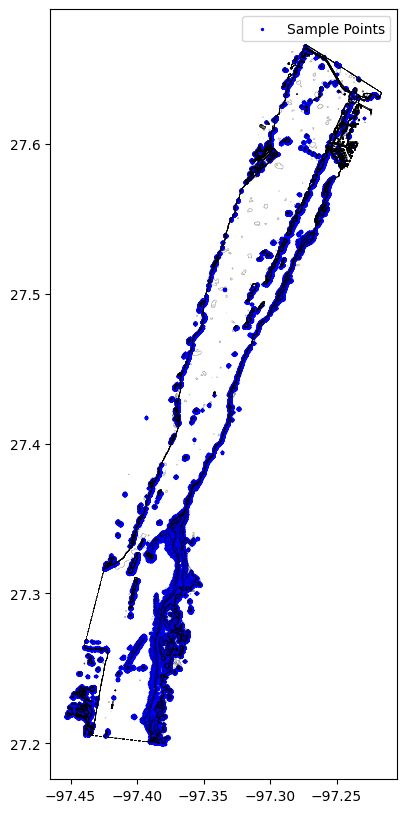

In [ ]:
# List to store sampled points and water levels
sample_points = []
water_levels = []

for idx, row in gdf_3.iterrows():
    geom = row.geometry
    level = row['water_leve']  # Replace with actual field name if different

    # Handle different geometry types
    if isinstance(geom, (Polygon, MultiPolygon)):
        # Handle Polygon and MultiPolygon geometries
        polygons = [geom] if isinstance(geom, Polygon) else list(geom.geoms)
        for poly in polygons:
            for coord in poly.exterior.coords:
                sample_points.append(coord)
                water_levels.append(level)

            # If there are holes (interiors), handle those too
            for interior in poly.interiors:
                for coord in interior.coords:
                    sample_points.append(coord)
                    water_levels.append(level)

    elif isinstance(geom, (LineString, MultiLineString)):
        # Handle LineString and MultiLineString geometries
        lines = [geom] if isinstance(geom, LineString) else list(geom.geoms)
        for line in lines:
            for coord in line.coords:
                sample_points.append(coord)
                water_levels.append(level)

# Convert sample points and water levels into a GeoDataFrame
sample_points_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(*zip(*sample_points)),
                                     data={'water_level': water_levels},
                                     crs="EPSG:4326")  # Ensure CRS is correct for your dataset

## Visualize sample points
# Plot the points
fig, ax = plt.subplots(figsize=(10, 10))
sample_points_gdf.plot(ax=ax, color='blue', markersize=2, label='Sample Points')

# Optionally, you can also plot the waterlines (if needed)
gdf.plot(ax=ax, color='black', alpha=0.5, linewidth=0.5, label='Waterlines')

plt.legend()
plt.show()


In [ ]:
# Export the sample points GeoDataFrame to a shapefile
#sample_points_gdf.to_file("/content/gdrive/My Drive/sample_points.shp")

In [ ]:
### KRIGING APPROACH April 14, 2025

# Extract coordinates and water level values from GeoDataFrame
sample_coords = np.array([(point.x, point.y) for point in sample_points_gdf.geometry])
sample_values = np.array(sample_points_gdf['water_level'])  # Replace with correct column name

# Define grid spacing (approx. 10m resolution)
xmin, ymin, xmax, ymax = sample_points_gdf.total_bounds
grid_spacing = 10  # meters

# Generate grid (assumes your coordinates are in meters)
grid_x = np.arange(xmin, xmax, grid_spacing)
grid_y = np.arange(ymin, ymax, grid_spacing)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

In [ ]:
# Ordinary Kriging
OK = OrdinaryKriging(
    sample_coords[:, 0],  # x
    sample_coords[:, 1],  # y
    sample_values,        # z (water level)
    variogram_model='linear',  # or 'spherical', 'gaussian', 'exponential'
    verbose=False,
    enable_plotting=False
)

# Execute on the grid
#z_kriged, ss = OK.execute('grid', grid_x, grid_y)

## ======== CHECKPOINT =========== April 11, 2025
#### Interpolation in QGIS and/or ArcGIS Pro was successful, but I still can't get the interpolation in python. RAM memory issue using Kriging method

In [ ]:


'''
# IDW interpolation function
def idw_interpolation(points, values, grid_x, grid_y, power=2):
    # Create a mesh grid for the target locations
    grid_coords = np.array([grid_x.flatten(), grid_y.flatten()]).T

    # Calculate the distances between the grid points and sample points
    dist = distance.cdist(grid_coords, points)

    # Prevent division by zero (if a point is too close, set a minimum distance)
    dist[dist == 0] = 1e-10

    # Compute the weights using inverse distance
    weights = 1 / (dist ** power)

    # Normalize the weights to sum to 1
    weights /= weights.sum(axis=1)[:, np.newaxis]

    # Perform the weighted average
    grid_z = np.dot(weights, values)

    # Reshape to match the grid size
    return grid_z.reshape(grid_x.shape)


# List to store sampled points and water levels
sample_points = []
water_levels = []

# Extract sample points and corresponding water levels
for idx, row in gdf.iterrows():
    geom = row.geometry
    level = row['water_leve']  # Replace with actual field name if different

    # Handle different geometry types
    if isinstance(geom, (Polygon, MultiPolygon)):
        polygons = [geom] if isinstance(geom, Polygon) else list(geom.geoms)
        for poly in polygons:
            for coord in poly.exterior.coords:
                sample_points.append(coord)
                water_levels.append(level)

            # If there are holes (interiors), handle those too
            for interior in poly.interiors:
                for coord in interior.coords:
                    sample_points.append(coord)
                    water_levels.append(level)

    elif isinstance(geom, (LineString, MultiLineString)):
        lines = [geom] if isinstance(geom, LineString) else list(geom.geoms)
        for line in lines:
            for coord in line.coords:
                sample_points.append(coord)
                water_levels.append(level)

# Convert to numpy arrays for interpolation
coordinates = np.array(sample_points)
values = np.array(water_levels)

# Define the grid for interpolation (10m resolution)
xmin, ymin, xmax, ymax = gdf.total_bounds
grid_x, grid_y = np.mgrid[xmin:xmax:10j, ymin:ymax:10j]  # 1resolution

# Perform IDW interpolation
grid_z = idw_interpolation(coordinates, values, grid_x, grid_y, power=2)

# Mask NaN values if any
grid_z = np.ma.masked_invalid(grid_z)

# Plot the result
plt.figure(figsize=(10, 8))
plt.imshow(grid_z, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='terrain')
plt.colorbar(label='Water Level')
plt.title('Interpolated DEM (10m resolution)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display plot
plt.show()
'''

#### Export DEM

In [ ]:
'''

#!pip install rasterio
import rasterio
from rasterio.transform import from_origin

# Extract the coordinates and water levels
coordinates = np.array([point.coords[0] for point in gdf.geometry])
water_levels = gdf['water_leve'].values

# Step 2: Define the grid for interpolation (10m resolution)
xmin, ymin, xmax, ymax = gdf.total_bounds
grid_x, grid_y = np.mgrid[xmin:xmax:10, ymin:ymax:10]  # 10m resolution grid

# Step 3: Perform interpolation using IDW (or other method)
grid_z = griddata(coordinates, water_levels, (grid_x, grid_y), method='cubic')

# Step 4: Create the GeoTIFF
# Define the transform (top-left corner and pixel size)
transform = from_origin(xmin, ymax, 10, 10)  # 10m resolution, starting at (xmin, ymax)

# Step 5: Save as a GeoTIFF
output_raster_path = '/content/drive/MyDrive/DEM_output_10m_resolution.tif'

# Create the raster file
with rasterio.open(output_raster_path, 'w', driver='GTiff', height=grid_z.shape[0], width=grid_z.shape[1],
                   count=1, dtype='float32', crs='EPSG:32614', transform=transform) as dst:
    dst.write(grid_z, 1)

print(f"DEM has been saved as a GeoTIFF: {output_raster_path}")
'''